## 导入库

In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm
from torch.nn import functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, random_split, DataLoader

from DTC import DTC

## 模型

In [2]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.res = nn.Linear(n_inputs, n_outputs)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        out = self.net(x)
        res = self.res(torch.permute(x,(0,2,1)))
        return out + torch.permute(res, (0,2,1))


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, dila = True, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            if dila:
                dilation_size = 2 ** i
            else:
                dilation_size = 1
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        # self.u = nn.Linear(out_channels, num_cluster)
        self.network = nn.Sequential(*layers)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        X = []
        x = torch.permute(x, (0, 2, 1))
        for la in self.network:
            x = la(x)
            X.append(torch.permute(x, (0, 2, 1)))
        return torch.permute(x, (0, 2, 1)), X

In [3]:
class DRNN(nn.Module):

    def __init__(self, n_input, n_hiddens, dila=True, dropout=0, cell_type="RNN", batch_first=True):
        super().__init__()

        n_layers = len(n_hiddens)
        if dila:
            self.dilations = [2 ** i for i in range(n_layers)]
        else:
            self.dilations = [1] * n_layers
        self.cell_type = cell_type
        self.batch_first = batch_first

        layers = []
        if self.cell_type == "GRU":
            cell = nn.GRU
        elif self.cell_type == "RNN":
            cell = nn.RNN
        elif self.cell_type == "LSTM":
            cell = nn.LSTM
        else:
            raise NotImplementedError

        for i in range(n_layers):
            if i == 0:
                c = cell(n_input, n_hiddens[i], dropout=dropout)
            else:
                c = cell(n_hiddens[i-1], n_hiddens[i], dropout=dropout)
            layers.append(c)
        self.cells = nn.Sequential(*layers).cuda()

    def forward(self, inputs, hidden=None):
        if self.batch_first:
            inputs = inputs.transpose(1, 0)
        outputs = []
        for i, (cell, dilation) in enumerate(zip(self.cells, self.dilations)):
            if hidden is None:
                inputs, _ = self.drnn_layer(cell, inputs, dilation)
            else:
                inputs, hidden[i] = self.drnn_layer(cell, inputs, dilation, hidden[i])
            if self.batch_first:
                outputs.append(inputs.transpose(1, 0))
            else:
                outputs.append(inputs)
        if self.batch_first:
            inputs = inputs.transpose(1, 0)
        return inputs, outputs

    def drnn_layer(self, cell, inputs, rate, hidden=None):
        n_steps = len(inputs)
        batch_size = inputs[0].size(0)
        hidden_size = cell.hidden_size

        inputs, _ = self._pad_inputs(inputs, n_steps, rate)
        dilated_inputs = self._prepare_inputs(inputs, rate)

        if hidden is None:
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size)
        else:
            hidden = self._prepare_inputs(hidden, rate)
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size, hidden)

        splitted_outputs = self._split_outputs(dilated_outputs, rate)
        outputs = self._unpad_outputs(splitted_outputs, n_steps)
        return outputs, hidden

    def init_hidden(self, batch_size, hidden_dim):
        hidden = torch.zeros(batch_size, hidden_dim).cuda()
        if self.cell_type == "LSTM":
            memory = torch.zeros(batch_size, hidden_dim).cuda()
            return (hidden, memory)
        else:
            return hidden

    def _prepare_inputs(self, inputs, rate):
        dilated_inputs = torch.cat([inputs[j::rate, :, :] for j in range(rate)], 1)
        return dilated_inputs

    def _pad_inputs(self, inputs, n_steps, rate):
        is_even = (n_steps % rate) == 0

        if not is_even:
            dilated_steps = n_steps // rate + 1

            zeros_ = torch.zeros(dilated_steps * rate - inputs.size(0), inputs.size(1),inputs.size(2)).cuda()
            inputs = torch.cat((inputs, zeros_)).cuda()
        else:
            dilated_steps = n_steps // rate

        return inputs, dilated_steps

    def _split_outputs(self, dilated_outputs, rate):
        batchsize = dilated_outputs.size(1) // rate

        blocks = [dilated_outputs[:, i * batchsize: (i + 1) * batchsize, :] for i in range(rate)]
        interleaved = torch.stack(blocks).transpose(1, 0).contiguous()
        interleaved = interleaved.view(dilated_outputs.size(0) * rate, batchsize, dilated_outputs.size(2)).cuda()

        return interleaved

    def _unpad_outputs(self, splitted_outputs, n_steps):
        return splitted_outputs[:n_steps]

    def _apply_cell(self, dilated_inputs, cell, batch_size, rate, hidden_size, hidden=None):
        if hidden is None:
            if self.cell_type == 'LSTM':
                c, m = self.init_hidden(batch_size * rate, hidden_size)
                hidden = (c.unsqueeze(0), m.unsqueeze(0))
            else:
                hidden = self.init_hidden(batch_size * rate, hidden_size).unsqueeze(0)

        dilated_outputs, hidden = cell(dilated_inputs, hidden)

        return dilated_outputs, hidden

In [4]:
class selfAttention(nn.Module):
    def __init__(self, num_attention_heads, input_size, hidden_size):
        super().__init__()
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "the hidden size %d is not a multiple of the number of attention heads"
                "%d" % (hidden_size, num_attention_heads)
            )
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size

        self.key_layer = nn.Linear(input_size, hidden_size)
        self.query_layer = nn.Linear(input_size, hidden_size)
        self.value_layer = nn.Linear(input_size, hidden_size)
        self.inita()

    def inita(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
    def trans_to_multiple_heads(self, x):
        new_size = x.size()[ : -1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_size)
        return x.permute(0, 2, 1, 3)

    def forward(self, x):
        key = self.key_layer(x)
        query = self.query_layer(x)
        value = self.value_layer(x)

        key_heads = self.trans_to_multiple_heads(key)
        query_heads = self.trans_to_multiple_heads(query)
        value_heads = self.trans_to_multiple_heads(value)

        attention_scores = torch.matmul(query_heads, key_heads.permute(0, 1, 3, 2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        attention_probs = F.softmax(attention_scores, dim = -1)

        context = torch.matmul(attention_probs, value_heads)
        context = context.permute(0, 2, 1, 3).contiguous()
        new_size = context.size()[ : -2] + (self.all_head_size , )
        context = context.view(*new_size)
        return context

In [5]:
class encoder(nn.Module):
    def __init__(self, num_inputs=9, num_channels=[16, 32, 64, 32, 16], rnn_dim = 16, num_attention_heads=4, hidden_dim=32, combination=False, base_type=0):
        super().__init__()
        self.combination = combination
        self.base_type = base_type
        if base_type == 0:
            self.feature = TemporalConvNet(num_inputs, num_channels)
        else:
            self.feature = DRNN(num_inputs, num_channels)

        self.mlp = nn.Linear(sum(num_channels), num_channels[-1])
        self.rnn = nn.RNN(hidden_dim, rnn_dim, batch_first=True)
        self.attention = selfAttention(num_attention_heads, num_channels[-1], hidden_dim)

    def forward(self, x):
        feature, features = self.feature(x)
        if self.combination:
            feature = self.mlp(torch.concat(features, dim=-1))
        feature = self.attention(feature)
        feature, _ = self.rnn(feature)
        # feature = self.attention(feature)
        return feature

In [6]:
class Baseline(nn.Module):
    def __init__(self, base_encoder, num_inputs=9, num_channels=[16, 32, 64, 32, 16], rnn_dim = 16, num_attention_heads=4, hidden_dim=32, m=0.999, T=0.07, dila=True, combination=True, base_type=0):
        super().__init__()
        self.m = m
        self.T = T

        self.encoder = base_encoder(num_inputs, num_channels, rnn_dim, num_attention_heads, hidden_dim, combination, base_type).cuda()

        channels = num_channels.copy()
        channels.reverse()
        channels.append(num_inputs)
        if self.encoder.base_type == 0:
            self.decoder = TemporalConvNet(rnn_dim, channels, dila=False)
        else:
            self.decoder = DRNN(rnn_dim, channels, dila=False)
            # decoder = []
            # for i in range(len(channels)-1):
            #   decoder.append(nn.GRU(channels[i], channels[i+1], batch_first=True))
            # self.decoder = nn.Sequential(*decoder)

        # self.mlp = nn.Sequential(nn.Linear(rnn_dim, 2 * rnn_dim), nn.ReLU(), nn.Linear(2 * rnn_dim, rnn_dim))


    def forward(self, xh):
        hs = self.encoder(xh)
        return hs

    def fit(self, fh):
        hs = self(fh)
        # print(hs.shape)
        # h_n = hs[:,-1,:].squeeze()
        fh_d,_ = self.decoder(hs)
        # print(fh.shape, fh_d.shape)
        loss = torch.mean(torch.sum(torch.pow(fh - fh_d, 2), dim=-1))
        return loss

In [7]:
# 模型1：tcn
m1 = Baseline(encoder, base_type=0, combination=False)
# 模型2：tcn + combination
m2 = Baseline(encoder, base_type=0, combination=True)
# 模型3：tcn + distance calculation
params3 = dict(
    input_dim=9,
    num_channels=[16, 32, 64, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=0,
    combination=False
)
m3 = DTC(**params3)
# 模型4：tcn + combination + distance calculation
params4 = dict(
    input_dim=9,
    num_channels=[16, 32, 64, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=0,
    combination=True
)
m4 = DTC(**params4)
# 模型5：drnn
m5 = Baseline(encoder, base_type=1, combination=False, num_channels=[16, 16])
# 模型6：drnn + combination
m6 = Baseline(encoder, base_type=1, combination=True, num_channels=[16, 32])
# 模型7：drnn + distance calculation
params7 = dict(
    input_dim=9,
    num_channels=[16, 32],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=1,
    combination=False
)
m7 = DTC(**params7)
# 模型8：drnn + combination + distance calculation
params8 = dict(
    input_dim=9,
    num_channels=[16, 32],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=1,
    combination=True
)
m8 = DTC(**params8)

## 数据

In [8]:
import pickle

In [9]:
class TrajDataset(Dataset):
    def __init__(self, F, M, Index):
        self.F = pad_sequence(F, batch_first=True, padding_value=0)
        self.M = M
        self.Index = Index
        # print(self.F.shape, self.mask.shape)
    def __len__(self):
        return len(self.M)
    def __getitem__(self, index):
        return self.F[index], self.M[index], self.Index[index]

In [10]:
with open("Fs_tps_I1.pkl", "rb") as f:
    Fs = pickle.load(f)
with open("Index_tps_I1.pkl", "rb") as f:
    Index = pickle.load(f)
M = np.load("M_tps_I1.npy")

In [11]:
# 计算训练集和验证集的大小
Fs = [torch.tensor(f) for f in Fs]
# L = torch.tensor(L)
M = torch.tensor(M)

traw: 60000
dl: 25000
dre: 14000
ps: 20000
tps: 12500
tro: 60000

In [12]:
# 差点忘记归一化了
N_F = []
for f in Fs:
    N_F.append(f)
N_F = torch.cat(N_F)
N_F_mean = torch.mean(N_F, dim=0)
N_F_std = torch.std(N_F, dim=0)

In [13]:
Fs = [(f - N_F_mean) / N_F_std for f in Fs]

In [14]:
Fs_ = Fs[:10000]
M_ = M[:10000]
Index_ = Index[:10000]

In [15]:
dataset = TrajDataset(Fs_,  M_, Index_)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# 使用 random_split 分割数据集
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [16]:
# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=2000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2000, shuffle=False)

In [17]:
# 所有数据整合, 查看模型结果的时候使用
all_dataset = TrajDataset(Fs_,  M_, Index_)
all_loader = DataLoader(all_dataset, batch_size=2000, shuffle=False)

## 模型训练

### Model1

In [791]:
m1 = m1.cuda()

In [804]:
optimizer1 = optim.Adam(m1.parameters(), lr=1e-4, weight_decay=1e-2)

In [793]:
Loss1 = []

In [805]:
m1.train()
for i in range(10):
    Lo1 = 0
    print(i)
    for f, _,_ in all_loader:
        optimizer1.zero_grad()
        loss1 = m1.fit(f.float().cuda())
        loss1.backward()
        optimizer1.step()
        Lo1 += loss1.item()
    Loss1.append(Lo1 / len(all_loader))
    print(i, Loss1[-1])

0
0 0.5566857695579529
1
1 0.547176718711853
2
2 0.5397477805614471
3
3 0.5364017069339753
4
4 0.5343019068241119
5
5 0.532691216468811
6
6 0.5258238255977631
7
7 0.5256282985210419
8
8 0.5269212424755096
9
9 0.5180408418178558


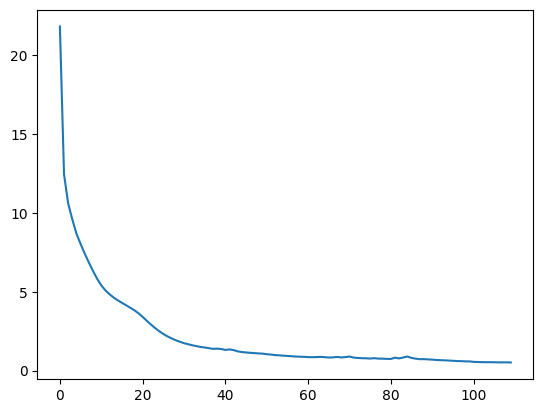

In [806]:
plt.plot(Loss1)

In [807]:
V1 = []
V1_ = []
m1.eval()
with torch.no_grad():
    for f, mmsi, index in all_loader:
        v1 = m1(f.float().cuda())
        for i in range(v1.shape[0]):
            V1.append(v1[i,-1,:].cpu().detach().numpy())
            V1_.append(v1[i,:,:].cpu().detach().numpy())

In [808]:
V1 = np.stack(V1)
V1_ = np.stack(V1_)

In [809]:
km1 = KMeans(n_clusters=2)
km1.fit(V1)
l1 = km1.predict(V1)

In [810]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(V1)

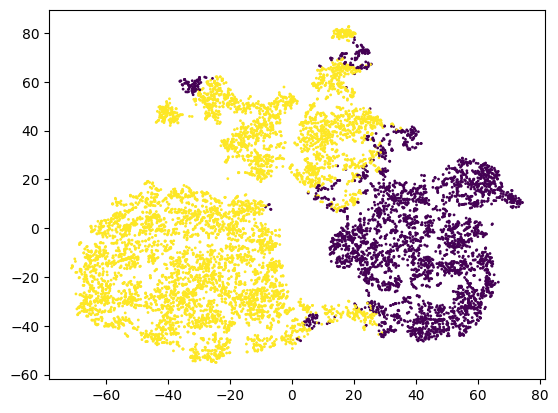

In [811]:
plt.scatter(X_tsne[:,0], X_tsne[:,1],s=1,c=l1)

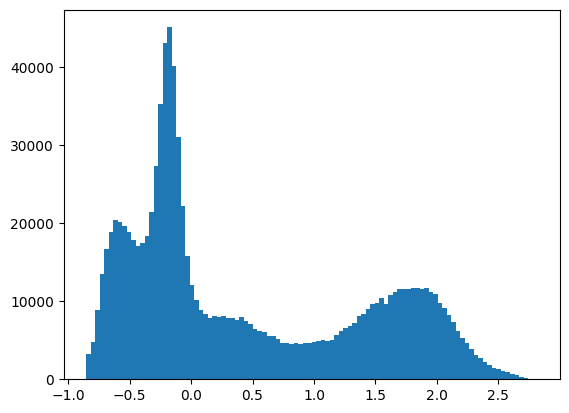

In [812]:
plt.hist(np.stack(Fs_).reshape(-1, 9)[:,0],bins=100)
plt.show()

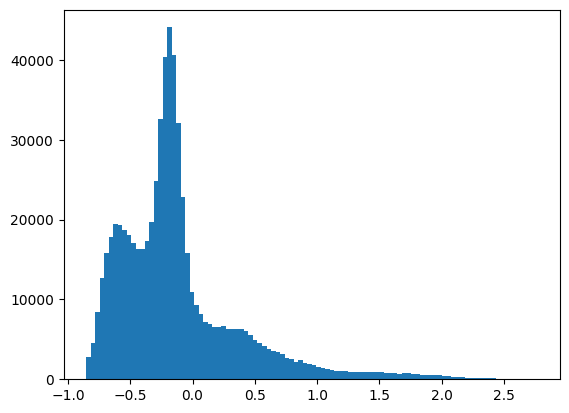

In [813]:
plt.hist(np.stack(Fs_).reshape(-1, 9)[np.stack([[i] * 100 for i in l1]).reshape(-1)==1,0],bins=100)
plt.show()

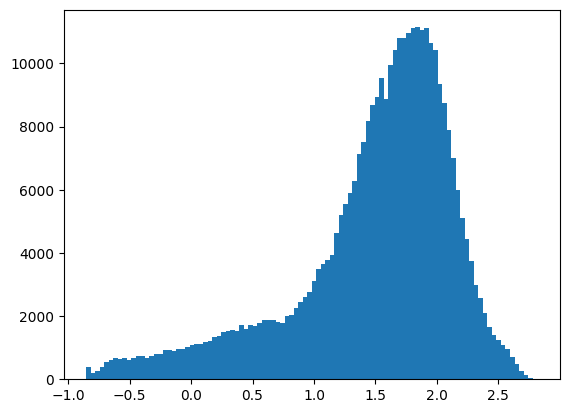

In [814]:
plt.hist(np.stack(Fs_).reshape(-1, 9)[np.stack([[i] * 100 for i in l1]).reshape(-1)==0,0],bins=100)
plt.show()

In [815]:
np.save("results4/tro_m1.npy",V1)
np.save("results4/tro_m1_all.npy",V1_)
torch.save(m1.state_dict(), "results4/m1_tro.pkl")

### Model2

In [816]:
m2 = m2.cuda()

In [817]:
optimizer2 = optim.Adam(m2.parameters(), lr=1e-3, weight_decay=1e-2)

In [818]:
Loss2 = []

In [819]:
for i in range(100):
    Lo2 = 0
    print(i)
    for f, _,_ in all_loader:
        optimizer2.zero_grad()
        loss2 = m2.fit(f.float().cuda())
        loss2.backward()
        optimizer2.step()
        Lo2 += loss2.item()
    Loss2.append(Lo2 / len(all_loader))
    print(i, Loss2[-1])

0
0 14.564891624450684
1
1 10.530981349945069
2
2 9.550927543640137
3
3 8.497042751312256
4
4 8.038666915893554
5
5 7.530622482299805
6
6 7.083332347869873
7
7 6.4746167182922365
8
8 5.868119525909424
9
9 5.336690425872803
10
10 4.90916953086853
11
11 4.589817810058594
12
12 4.290736055374145
13
13 4.049499607086181
14
14 3.7775455474853517
15
15 3.5319657802581785
16
16 3.2543308258056642
17
17 2.9844397068023683
18
18 2.7115242958068846
19
19 2.456056022644043
20
20 2.2505095958709718
21
21 2.0807666301727297
22
22 1.957148051261902
23
23 1.8472725391387939
24
24 1.766084337234497
25
25 1.69925057888031
26
26 1.6362545490264893
27
27 1.5812222480773925
28
28 1.531161856651306
29
29 1.4769609093666076
30
30 1.434605884552002
31
31 1.3861273407936097
32
32 1.3464386820793153
33
33 1.3116632103919983
34
34 1.2683220505714417
35
35 1.239487624168396
36
36 1.202696430683136
37
37 1.1732885479927062
38
38 1.1438263297080993
39
39 1.1283173561096191
40
40 1.1092689156532287
41
41 1.09613965

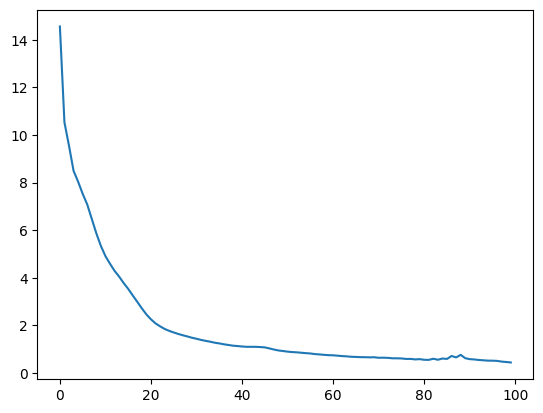

In [820]:
plt.plot(Loss2)

In [821]:
V2 = []
V2_ = []
m2.eval()
with torch.no_grad():
    for f, mmsi, index in all_loader:
        v2 = m2(f.float().cuda())
        for i in range(v2.shape[0]):
            V2.append(v2[i,-1,:].cpu().detach().numpy())
            V2_.append(v2[i,:,:].cpu().detach().numpy())

In [822]:
V2 = np.stack(V2)
V2_ = np.stack(V2_)

In [823]:
km2 = KMeans(n_clusters=2)
km2.fit(V2)
l2 = km2.predict(V2)

In [280]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne2 = tsne.fit_transform(V2)

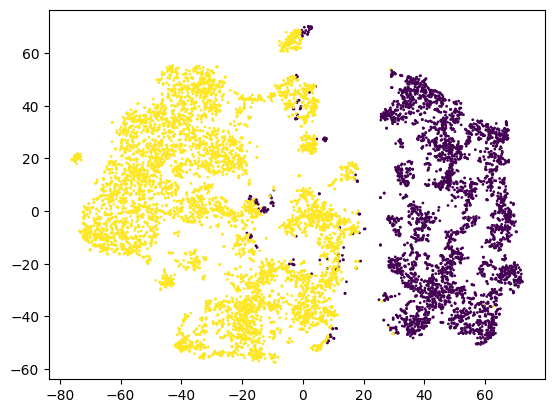

In [281]:
plt.scatter(X_tsne2[:,0], X_tsne2[:,1],s=1,c=l2)

In [826]:
torch.save(m2.state_dict(), "results4/m2_tro.pkl")

np.save("results4/tro_m2.npy",V2)
np.save("results4/tro_m2_all.npy",V2_)

In [825]:
np.sum(l1 != l2) / len(l1)

0.9699

### Model3

In [827]:
m3 = m3.cuda()

In [828]:
optimizer3 = optim.Adam(m3.parameters(), lr=1e-3, weight_decay=0.01)

In [829]:
Pre_Loss3 = []

In [830]:
for i in range(100):
    print("pre_train", i)
    Lo3 = 0
    # print(i)
    for f, _,_ in all_loader:
        optimizer3.zero_grad()
        _, loss3,_ = m3.loss(f.float().cuda())
            # loss_sum += loss
        loss3.backward()
        optimizer3.step()
        Lo3 += loss3.item()
    Pre_Loss3.append(Lo3 / len(all_loader))
    print(i, Pre_Loss3[-1])

pre_train 0
0 22.578728675842285
pre_train 1
1 12.096149444580078
pre_train 2
2 10.29882984161377
pre_train 3
3 9.358274364471436
pre_train 4
4 8.59049425125122
pre_train 5
5 7.880974864959716
pre_train 6
6 7.342561054229736
pre_train 7
7 6.832220649719238
pre_train 8
8 6.350458240509033
pre_train 9
9 5.956033992767334
pre_train 10
10 5.582668113708496
pre_train 11
11 5.262048673629761
pre_train 12
12 4.973452138900757
pre_train 13
13 4.717836666107178
pre_train 14
14 4.492968893051147
pre_train 15
15 4.282802438735962
pre_train 16
16 4.074376153945923
pre_train 17
17 3.888850975036621
pre_train 18
18 3.693257188796997
pre_train 19
19 3.511955976486206
pre_train 20
20 3.3161570549011232
pre_train 21
21 3.1288257122039793
pre_train 22
22 2.926610732078552
pre_train 23
23 2.739074873924255
pre_train 24
24 2.556613492965698
pre_train 25
25 2.386533260345459
pre_train 26
26 2.2269747972488405
pre_train 27
27 2.09581937789917
pre_train 28
28 1.9786399364471436
pre_train 29
29 1.875400233268

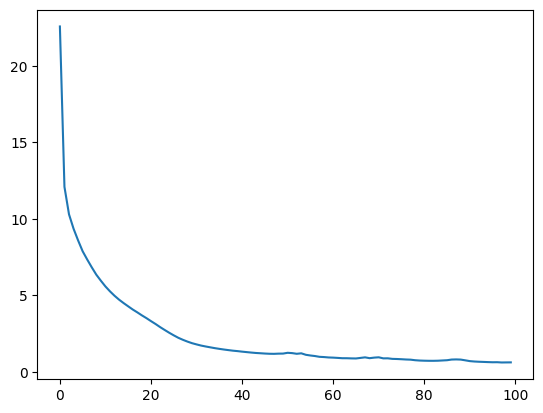

In [831]:
plt.plot(Pre_Loss3)

In [661]:
# m3 = m3.cuda()
# m3.load_state_dict(torch.load("parameters/m3_dre_pre.pkl"))

In [662]:
# torch.save(m3.state_dict(), "parameters/m3_tro_pre.pkl")

In [663]:
# m3.load_state_dict(torch.load("parameters/m3_tps_pre.pkl"))

In [664]:
# m3.load_state_dict(torch.load("parameters/m3_tro_pre.pkl"))

In [832]:
Loss3 = []
m3.init_centroids(all_loader)

In [833]:
optimizer3 = optim.Adam(m3.parameters(), lr=1e-4, weight_decay=1e-2)

In [834]:
m3.train()
for i in range(50):
    print("train", i)
    Lo3 = 0
    # print(i)
    for f, _,_ in all_loader:
        optimizer3.zero_grad()
        loss3_1, loss3_2, loss3_3 = m3.loss(f.float().cuda())
        loss3 = 10 * loss3_1 + loss3_2 + 10 * loss3_3
        loss3.backward()
        optimizer3.step()
        Lo3 += loss3.item()
    Loss3.append(Lo3 / len(all_loader))
    print(i, Loss3[-1])

train 0
0 26.31323356628418
train 1
1 25.445615005493163
train 2
2 24.912649154663086
train 3
3 24.474477005004882
train 4
4 24.175661087036133
train 5
5 23.63512763977051
train 6
6 23.31767807006836
train 7
7 23.081678009033205
train 8
8 22.631107330322266
train 9
9 22.555550384521485
train 10
10 22.347151947021484
train 11
11 22.285005569458008
train 12
12 22.19852523803711
train 13
13 22.044108581542968
train 14
14 22.1186580657959
train 15
15 21.99326171875
train 16
16 21.915993881225585
train 17
17 21.811868286132814
train 18
18 21.70618133544922
train 19
19 21.672229766845703
train 20
20 21.60005416870117
train 21
21 21.420817947387697
train 22
22 21.35838394165039
train 23
23 21.29363594055176
train 24
24 21.33793411254883
train 25
25 21.1848445892334
train 26
26 21.08343505859375
train 27
27 21.083427810668944
train 28
28 20.990080642700196
train 29
29 20.838490676879882
train 30
30 20.840908432006835
train 31
31 20.567010498046876
train 32
32 20.716140747070312
train 33
33 20.

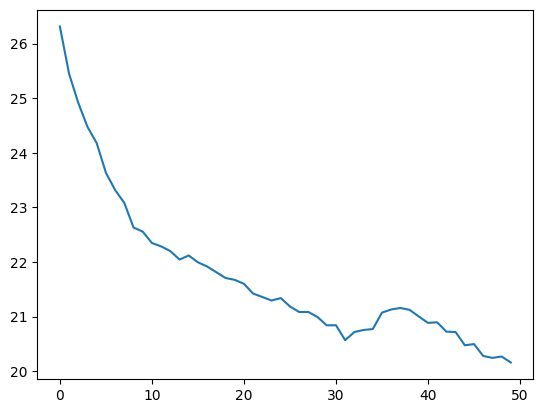

In [835]:
plt.plot(Loss3)

In [836]:
V3 = []
V3_ = []
m3.eval()
with torch.no_grad():
    for f, mmsi, index in all_loader:
        v3 = m3(f.float().cuda())
        for i in range(v3.shape[0]):
            V3.append(v3[i,-1,:].cpu().detach().numpy())
            V3_.append(v3[i,:,:].cpu().detach().numpy())

In [837]:
center_traw3 = m3.cluster.cpu().detach().numpy()
V3 = np.stack(V3)
V3_ = np.stack(V3_)

In [838]:
l3 = np.argmin(np.sum(np.power(V3[:, np.newaxis,:] - center_traw3[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [297]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne3 = tsne.fit_transform(V3)

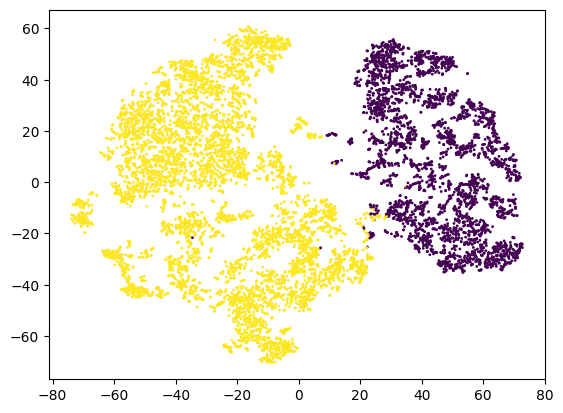

In [298]:
plt.scatter(X_tsne3[:,0], X_tsne3[:,1],s=1,c=l3)

In [840]:
torch.save(m3.state_dict(), "results4/m3_tro.pkl")

np.save("results4/tro_m3_center.npy", center_traw3)
np.save("results4/tro_m3.npy",V3)
np.save("results4/tro_m3_all.npy",V3_)

In [839]:
np.sum(l1 == l3) / len(l3)

0.0355

### Model 4

In [841]:
m4 = m4.cuda()

In [842]:
optimizer4 = optim.Adam(m4.parameters(), lr=1e-3, weight_decay=1e-2)

In [843]:
Pre_Loss4 = []

In [844]:
for i in range(100):
    print("pre_train", i)
    Lo4 = 0
    # print(i)
    for f, _,_ in all_loader:
        optimizer4.zero_grad()
        _, loss4,_ = m4.loss(f.float().cuda())
            # loss_sum += loss
        loss4.backward()
        optimizer4.step()
        Lo4 += loss4.item()
    Pre_Loss4.append(Lo4 / len(all_loader))
    print(i, Pre_Loss4[-1])

pre_train 0
0 15.4646240234375
pre_train 1
1 11.016119766235352
pre_train 2
2 9.663409805297851
pre_train 3
3 8.661209106445312
pre_train 4
4 7.774023532867432
pre_train 5
5 6.982835674285889
pre_train 6
6 6.338817596435547
pre_train 7
7 5.686229181289673
pre_train 8
8 5.171530389785767
pre_train 9
9 4.736924028396606
pre_train 10
10 4.31612377166748
pre_train 11
11 3.933886003494263
pre_train 12
12 3.577135992050171
pre_train 13
13 3.2551918983459474
pre_train 14
14 2.9774365425109863
pre_train 15
15 2.7306438446044923
pre_train 16
16 2.5230715751647947
pre_train 17
17 2.3478283882141113
pre_train 18
18 2.2044706106185914
pre_train 19
19 2.0710728406906127
pre_train 20
20 1.9572132110595704
pre_train 21
21 1.8594165563583374
pre_train 22
22 1.7802011013031005
pre_train 23
23 1.7066028118133545
pre_train 24
24 1.6414297580718995
pre_train 25
25 1.5811789989471436
pre_train 26
26 1.537313747406006
pre_train 27
27 1.5005889892578126
pre_train 28
28 1.4905617237091064
pre_train 29
29 1.45

In [2]:
# plt.plot(Pre_Loss4)

In [97]:
# torch.save(m4.state_dict(), "parameters/m4_tro_pre.pkl")

In [101]:
# m4 = m4.cuda()
# m4.load_state_dict(torch.load("parameters/m4_traw_pre.pkl"))

In [845]:
Loss4 = []
m4.init_centroids(all_loader)

In [846]:
optimizer4 = optim.Adam(m4.parameters(), lr=1e-4, weight_decay=1e-2)

In [847]:
m4.train()
for i in range(50):
    print("train", i)
    Lo4 = 0
    # print(i)
    for f, _,_ in all_loader:
        optimizer4.zero_grad()
        loss4_1, loss4_2, loss4_3 = m4.loss(f.float().cuda())
        loss4 = 10 * loss4_1 + loss4_2 + 10 * loss4_3
        loss4.backward()
        optimizer4.step()
        Lo4 += loss4.item()
    Loss4.append(Lo4 / len(all_loader))
    print(i, Loss4[-1])

train 0
0 25.033872604370117
train 1
1 24.15370979309082
train 2
2 23.173754119873045
train 3
3 22.37769889831543
train 4
4 21.812832260131835
train 5
5 21.302667236328126
train 6
6 21.067057037353514
train 7
7 20.638071823120118
train 8
8 20.333129119873046
train 9
9 20.00331230163574
train 10
10 19.757789611816406
train 11
11 19.63727722167969
train 12
12 19.43295822143555
train 13
13 19.135461807250977
train 14
14 19.011423873901368
train 15
15 18.913917541503906
train 16
16 18.831863784790038
train 17
17 18.736424255371094
train 18
18 18.566477584838868
train 19
19 18.36780548095703
train 20
20 18.225231552124022
train 21
21 18.058491897583007
train 22
22 17.905292510986328
train 23
23 17.856304550170897
train 24
24 17.693545532226562
train 25
25 17.594990539550782
train 26
26 17.49160842895508
train 27
27 17.442737579345703
train 28
28 17.435043334960938
train 29
29 17.4081449508667
train 30
30 17.2906436920166
train 31
31 17.301210975646974
train 32
32 17.169637870788574
train 33

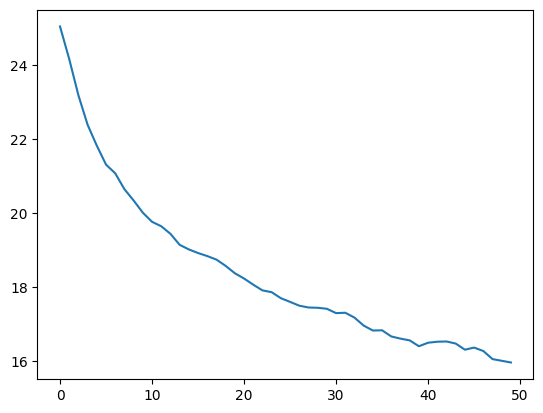

In [848]:
plt.plot(Loss4)

In [849]:
V4 = []
V4_ = []
m4.eval()
with torch.no_grad():
    for f, mmsi, index in all_loader:
        v4 = m4(f.float().cuda())
        for i in range(v4.shape[0]):
            V4.append(v4[i,-1,:].cpu().detach().numpy())
            V4_.append(v4[i,:,:].cpu().detach().numpy())

In [850]:
center_traw4 = m4.cluster.cpu().detach().numpy()
V4 = np.stack(V4)
V4_ = np.stack(V4_)

l4 = np.argmin(np.sum(np.power(V4[:, np.newaxis,:] - center_traw4[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [312]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne4 = tsne.fit_transform(V4)

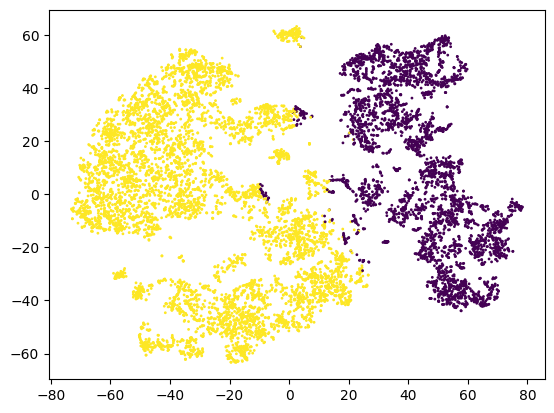

In [313]:
plt.scatter(X_tsne4[:,0], X_tsne4[:,1],s=1,c=l4)

In [853]:
torch.save(m4.state_dict(), "results4/m4_tro.pkl")

np.save("results4/tro_m4_center.npy", center_traw4)
np.save("results4/tro_m4.npy",V4)
np.save("results4/tro_m4_all.npy",V4_)

In [852]:
np.sum(l2 != l4) / len(l4)

0.0254

In [119]:
# torch.save(m4.state_dict(), "parameters/m4_tro_after.pkl")

### Model 5

In [18]:
m5 = m5.cuda()

In [19]:
optimizer5 = optim.Adam(m5.parameters(), lr=1e-3)

/root/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
Loss5 = []

In [21]:
m5.train()
for i in range(200):
    Lo5 = 0
    print(i)
    for f, _,_ in all_loader:
        optimizer5.zero_grad()
        loss5 = m5.fit(f.float().cuda())
        loss5.backward()
        optimizer5.step()
        Lo5 += loss5.item()
    Loss5.append(Lo5 / len(all_loader))
    print(i, Loss5[-1])

0
0 9.81068000793457
1
1 9.245783805847168
2
2 8.907750701904297
3
3 8.556959533691407
4
4 8.162764549255371
5
5 7.797254753112793
6
6 7.456497001647949
7
7 7.090627765655517
8
8 6.734215259552002
9
9 6.397364521026612
10
10 6.085316944122314
11
11 5.834729385375977
12
12 5.625954246520996
13
13 5.456330299377441
14
14 5.319168186187744
15
15 5.202091026306152
16
16 5.108674621582031
17
17 5.033541965484619
18
18 4.970770168304443
19
19 4.9147844314575195
20
20 4.863374996185303
21
21 4.81399393081665
22
22 4.767369365692138
23
23 4.721940898895264
24
24 4.676887702941895
25
25 4.633028984069824
26
26 4.589561462402344
27
27 4.546776819229126
28
28 4.506367111206055
29
29 4.466503286361695
30
30 4.429515981674195
31
31 4.393924808502197
32
32 4.359934902191162
33
33 4.328008604049683
34
34 4.297506284713745
35
35 4.266202163696289
36
36 4.237766408920288
37
37 4.208824539184571
38
38 4.1788890838623045
39
39 4.150617790222168
40
40 4.1221582889556885
41
41 4.091979312896728
42
42 4.064

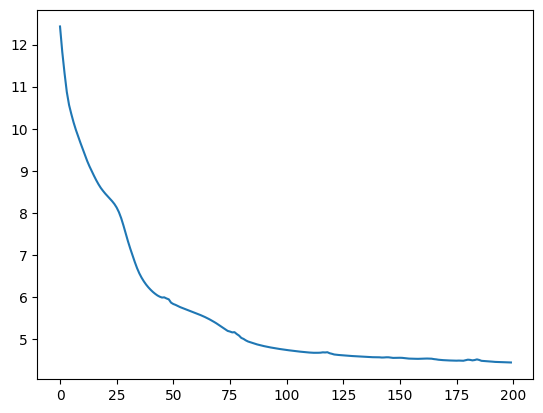

In [859]:
plt.plot(Loss5)

In [69]:
# torch.save(m5.state_dict(), "parameters1/m5_tra.pkl")

In [22]:
m5.eval()
V5 = []
V5_ = []
with torch.no_grad():
    for f, mmsi, index in all_loader:
        v5 = m5(f.float().cuda())
        for i in range(v5.shape[0]):
            V5.append(v5[i,-1,:].cpu().detach().numpy())
            V5_.append(v5[i,:,:].cpu().detach().numpy())

In [23]:
V5 = np.stack(V5)
V5_ = np.stack(V5_)

In [24]:
km5 = KMeans(n_clusters=2)
km5.fit(V5)
l5 = km5.predict(V5)

In [25]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne5 = tsne.fit_transform(V5)

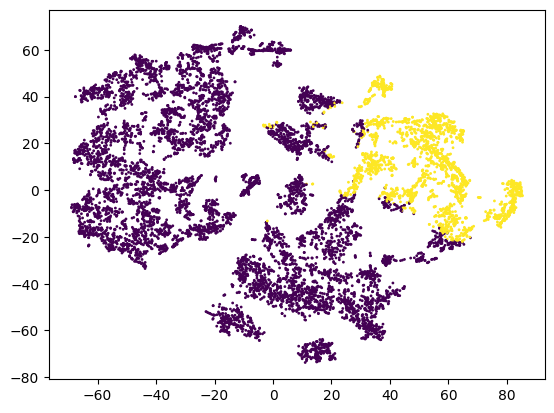

In [26]:
plt.scatter(X_tsne5[:,0], X_tsne5[:,1],s=1,c=l5)

In [27]:
torch.save(m5.state_dict(), "m5_tps.pkl")

np.save("tps_m5.npy",V5)
np.save("tps_m5_all.npy",V5_)

In [136]:
# np.save("results1/trawl_m5.npy",np.stack(V5))

In [863]:
np.sum(l1 == l5)

9459

### Model 6

In [865]:
m6 = m6.cuda()

optimizer6 = optim.Adam(m6.parameters(), lr=1e-3)

In [866]:
# m6.load_state_dict(torch.load("parameters1/m6_tra.pkl"))

In [867]:
Loss6 = []

In [874]:
m6.train()
for i in range(100):
    Lo6 = 0
    print(i)
    for f, _,_ in all_loader:
        optimizer6.zero_grad()
        loss6 = m6.fit(f.float().cuda())
        loss6.backward()
        optimizer6.step()
        Lo6 += loss6.item()
    Loss6.append(Lo6 / len(all_loader))
    print(i, Loss6[-1])

0
0 4.6296618461608885
1
1 4.626935863494873
2
2 4.6339741230010985
3
3 4.638841867446899
4
4 4.661249017715454
5
5 4.686452054977417
6
6 4.677581834793091
7
7 4.651416778564453
8
8 4.606841945648194
9
9 4.5949766635894775
10
10 4.588733434677124
11
11 4.576720094680786
12
12 4.5717462539672855
13
13 4.566279411315918
14
14 4.564164018630981
15
15 4.560522222518921
16
16 4.557269716262818
17
17 4.553833961486816
18
18 4.549883556365967
19
19 4.546009063720703
20
20 4.5412074565887455
21
21 4.537953186035156
22
22 4.532606220245361
23
23 4.53144679069519
24
24 4.527179479598999
25
25 4.529510641098023
26
26 4.528613758087158
27
27 4.53473482131958
28
28 4.537964773178101
29
29 4.547599029541016
30
30 4.548434495925903
31
31 4.542095422744751
32
32 4.528520727157593
33
33 4.516728448867798
34
34 4.51869764328003
35
35 4.513046836853027
36
36 4.508906650543213
37
37 4.503878498077393
38
38 4.495188045501709
39
39 4.495254135131836
40
40 4.487763404846191
41
41 4.4885200500488285
42
42 4.4

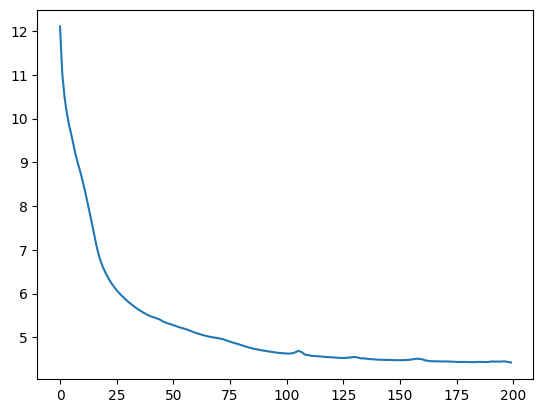

In [875]:
plt.plot(Loss6)

In [142]:
# torch.save(m6.state_dict(), "parameters1/m6_tra1.pkl")

In [876]:
V6 = []
V6_ = []
m6.eval()
with torch.no_grad():
    for f, mmsi, index in all_loader:
        v6 = m6(f.float().cuda())
        for i in range(v6.shape[0]):
            V6.append(v6[i,-1,:].cpu().detach().numpy())
            V6_.append(v6[i,:,:].cpu().detach().numpy())


In [877]:
V6 = np.stack(V6)
V6_ = np.stack(V6_)

In [878]:
km6 = KMeans(n_clusters=2)
km6.fit(V6)
l6 = km6.predict(V6)

In [105]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne6 = tsne.fit_transform(V6)

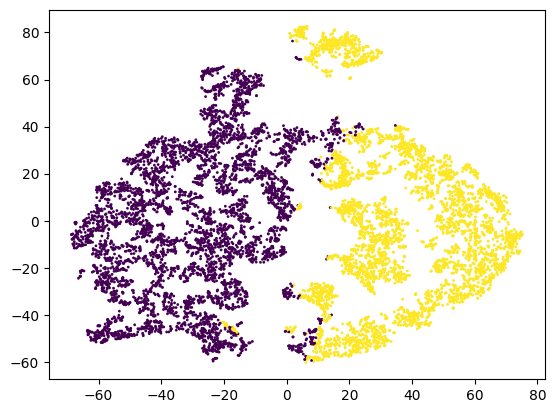

In [107]:
plt.scatter(X_tsne6[:,0], X_tsne6[:,1],s=1,c=l6)

In [880]:
torch.save(m6.state_dict(), "results4/m6_tro.pkl")

np.save("results4/tro_m6.npy",V6)
np.save("results4/tro_m6_all.npy",V6_)

In [879]:
np.sum(l1 == l6)

444

### Model 7

In [979]:
m7 = m7.cuda()

optimizer7 = optim.Adam(m7.parameters(), lr=1e-2, weight_decay=1e-10)

In [980]:
Pre_Loss7 = []

In [981]:
m7.train()
for i in range(100):
    print("pre_train", i)
    Lo7 = 0
    # print(i)
    for f, _,_ in all_loader:
        optimizer7.zero_grad()
        _, loss7,_ = m7.loss(f.float().cuda())
            # loss_sum += loss
        loss7.backward()
        optimizer7.step()
        Lo7 += loss7.item()
    Pre_Loss7.append(Lo7 / len(all_loader))
    print(i, Pre_Loss7[-1])

pre_train 0
0 11.426813125610352
pre_train 1
1 9.399973011016845
pre_train 2
2 8.771073818206787
pre_train 3
3 8.490731048583985
pre_train 4
4 8.34650535583496
pre_train 5
5 8.208917903900147
pre_train 6
6 8.095494651794434
pre_train 7
7 7.964252185821533
pre_train 8
8 7.816041374206543
pre_train 9
9 7.559254932403564
pre_train 10
10 7.166073608398437
pre_train 11
11 6.8033064842224125
pre_train 12
12 6.476643753051758
pre_train 13
13 6.236928129196167
pre_train 14
14 6.0235494613647464
pre_train 15
15 5.784417581558228
pre_train 16
16 5.703217840194702
pre_train 17
17 5.511487102508545
pre_train 18
18 5.37701416015625
pre_train 19
19 5.301594877243042
pre_train 20
20 5.229602479934693
pre_train 21
21 5.257039594650268
pre_train 22
22 5.1519121646881105
pre_train 23
23 5.093469333648682
pre_train 24
24 5.072192049026489
pre_train 25
25 5.020143222808838
pre_train 26
26 4.956465864181519
pre_train 27
27 4.935710906982422
pre_train 28
28 4.903577661514282
pre_train 29
29 4.88055171966552

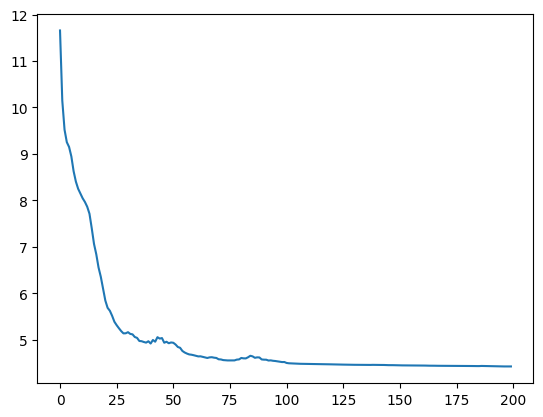

In [948]:
plt.plot(Pre_Loss7)

In [154]:
# torch.save(m7.state_dict(), "parameters1/m7_tra_pre.pkl")

In [25]:
# m7.load_state_dict(torch.load("parameters/m7_dl_pre.pkl"))

In [26]:
# m7.load_state_dict(torch.load("parameters/m7_traw_pre.pkl"))

In [982]:
Loss7 = []
m7.init_centroids(all_loader)

In [983]:
optimizer7 = optim.Adam(m7.parameters(), lr=1e-4, weight_decay=1e-10)

In [984]:
m7.train()
for i in range(50):
    print("train", i)
    Lo7 = 0
    # print(i)
    for f, _,_ in all_loader:
        optimizer7.zero_grad()
        loss7_1, loss7_2, loss7_3 = m7.loss(f.float().cuda())
        loss7 = 10 * loss7_1 + loss7_2 + 10 * loss7_3
        loss7.backward()
        optimizer7.step()
        Lo7 += loss7.item()
    Loss7.append(Lo7 / len(all_loader))
    print(i, Loss7[-1])

train 0
0 28.338824462890624
train 1
1 28.16615219116211
train 2
2 28.156918716430663
train 3
3 28.134460830688475
train 4
4 28.0964656829834
train 5
5 28.010757827758788
train 6
6 27.93228874206543
train 7
7 27.85604133605957
train 8
8 27.788572692871092
train 9
9 27.724901580810545
train 10
10 27.682853317260744
train 11
11 27.60526466369629
train 12
12 27.542554092407226
train 13
13 27.485056686401368
train 14
14 27.436924743652344
train 15
15 27.322650527954103
train 16
16 27.243897247314454
train 17
17 27.186328125
train 18
18 27.137320709228515
train 19
19 27.102985000610353
train 20
20 27.073789978027342
train 21
21 27.025536727905273
train 22
22 26.984376907348633
train 23
23 26.944862365722656
train 24
24 26.909646606445314
train 25
25 26.87710075378418
train 26
26 26.846126556396484
train 27
27 26.816055679321288
train 28
28 26.78656997680664
train 29
29 26.757488632202147
train 30
30 26.728598022460936
train 31
31 26.69973030090332
train 32
32 26.67085380554199
train 33
33 2

In [985]:
V7 = []
V7_ = []
m7.eval()
with torch.no_grad():
    for f, mmsi, index in all_loader:
        v7 = m7(f.float().cuda())
        for i in range(v7.shape[0]):
            V7.append(v7[i,-1,:].cpu().detach().numpy())
            V7_.append(v7[i,:,:].cpu().detach().numpy())

In [986]:
center_traw7 = m7.cluster.cpu().detach().numpy()
V7 = np.stack(V7)
V7_ = np.stack(V7_)

l7 = np.argmin(np.sum(np.power(V7[:, np.newaxis,:] - center_traw7[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [924]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne7 = tsne.fit_transform(V7)

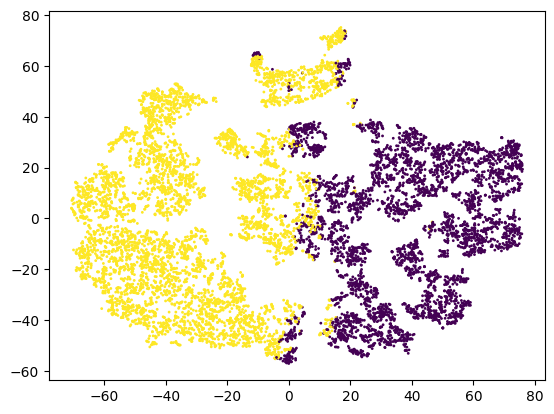

In [925]:
plt.scatter(X_tsne7[:,0], X_tsne7[:,1], s=1, c=l7)

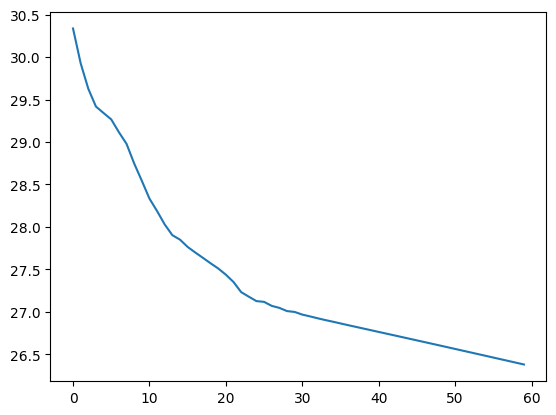

In [122]:
plt.plot(Loss7)

In [170]:
# torch.save(m7.state_dict(), "parameters1/m7_tra_after1.pkl")

In [171]:
# V7 = []
# with torch.no_grad():
#     for f, mmsi, index in all_loader:
#         v7 = m7(f.float().cuda())
#         for i in range(v7.shape[0]):
#             V7.append(v7[i,-1,:].cpu().detach().numpy())

# np.save("results1/trawl_m71.npy",np.stack(V7))

# np.save("results1/trawl_m71_center.npy", m7.cluster.detach().cpu().numpy())

In [988]:
torch.save(m7.state_dict(), "results4/m7_tro.pkl")

np.save("results4/tro_m7_center.npy", center_traw7)
np.save("results4/tro_m7.npy",V7)
np.save("results4/tro_m7_all.npy",V7_)

In [987]:
np.sum(l1 != l7) / len(l7)

0.0495

### Model 8

In [1022]:
m8 = m8.cuda()

optimizer8 = optim.Adam(m8.parameters(), lr=1e-2)

In [1023]:
Pre_Loss8 = []

In [1024]:
m8.train()
for i in range(100):
    print("pre_train", i)
    Lo8 = 0
    # print(i)
    for f, _,_ in all_loader:
        optimizer8.zero_grad()
        _, loss8,_ = m8.loss(f.float().cuda())
            # loss_sum += loss
        loss8.backward()
        optimizer8.step()
        Lo8 += loss8.item()
    Pre_Loss8.append(Lo8 / len(all_loader))
    print(i, Pre_Loss8[-1])

pre_train 0
0 11.029711818695068
pre_train 1
1 9.263366794586181
pre_train 2
2 8.64947509765625
pre_train 3
3 8.35773811340332
pre_train 4
4 8.172559261322021
pre_train 5
5 7.941824340820313
pre_train 6
6 7.620217418670654
pre_train 7
7 7.137014579772949
pre_train 8
8 6.667639446258545
pre_train 9
9 6.320087814331055
pre_train 10
10 6.022514533996582
pre_train 11
11 5.832703113555908
pre_train 12
12 5.681006050109863
pre_train 13
13 5.545235633850098
pre_train 14
14 5.402786922454834
pre_train 15
15 5.323446226119995
pre_train 16
16 5.255708074569702
pre_train 17
17 5.249136066436767
pre_train 18
18 5.148456621170044
pre_train 19
19 5.112631797790527
pre_train 20
20 5.071335983276367
pre_train 21
21 5.082765007019043
pre_train 22
22 5.057420015335083
pre_train 23
23 5.05335431098938
pre_train 24
24 5.061928796768188
pre_train 25
25 5.037114953994751
pre_train 26
26 4.978608798980713
pre_train 27
27 4.9656627655029295
pre_train 28
28 4.910740804672241
pre_train 29
29 4.870212888717651
p

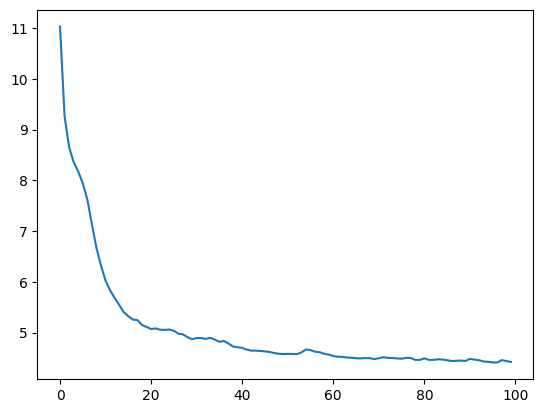

In [1025]:
plt.plot(Pre_Loss8)

In [193]:
# torch.save(m8.state_dict(), "parameters1/m8_tra_pre.pkl")

In [25]:
# m8.load_state_dict(torch.load("parameters/m8_tro_pre.pkl"))

In [1026]:
Loss8 = []
m8.init_centroids(all_loader)

In [1027]:
optimizer8 = optim.Adam(m8.parameters(), lr=1e-4)

In [1033]:
m8.train()
for i in range(50):
    print("train", i)
    Lo8 = 0
    # print(i)
    for f, _,_ in all_loader:
        optimizer8.zero_grad()
        loss8_1, loss8_2, loss8_3 = m8.loss(f.float().cuda())
        loss8 = 10 * loss8_1 + loss8_2 +  10*loss8_3
        loss8.backward()
        optimizer8.step()
        Lo8 += loss8.item()
    Loss8.append(Lo8 / len(all_loader))
    print(i, Loss8[-1])

train 0
0 28.826435470581053
train 1
1 28.771521377563477
train 2
2 28.716930770874022
train 3
3 28.662671279907226
train 4
4 28.608767700195312
train 5
5 28.555221176147462
train 6
6 28.502046966552733
train 7
7 28.449252319335937
train 8
8 28.39684600830078
train 9
9 28.344816589355467
train 10
10 28.29317398071289
train 11
11 28.241900634765624
train 12
12 28.19099655151367
train 13
13 28.14046401977539
train 14
14 28.09030418395996
train 15
15 28.04051399230957
train 16
16 27.991115188598634
train 17
17 27.942096710205078
train 18
18 27.8934684753418
train 19
19 27.845227813720705
train 20
20 27.797365570068358
train 21
21 27.749888229370118
train 22
22 27.702779388427736
train 23
23 27.6560302734375
train 24
24 27.60964469909668
train 25
25 27.563608169555664
train 26
26 27.51791915893555
train 27
27 27.472575759887697
train 28
28 27.427571105957032
train 29
29 27.382899475097656
train 30
30 27.33855743408203
train 31
31 27.294536590576172
train 32
32 27.25083351135254
train 33
33

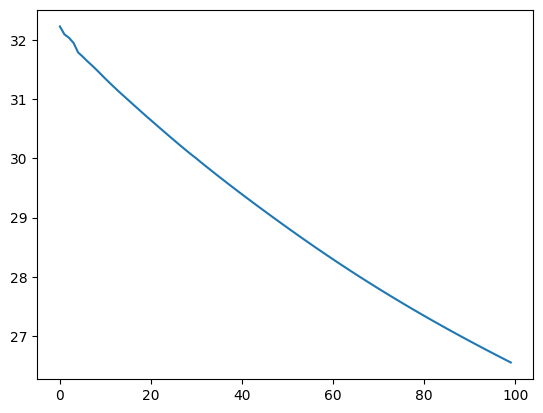

In [1034]:
plt.plot(Loss8)

In [197]:
# torch.save(m8.state_dict(), "parameters1/m8_tra_after3.pkl")

In [198]:
# V8 = []
# with torch.no_grad():
#     for f, mmsi, index in all_loader:
#         v8 = m8(f.float().cuda())
#         for i in range(v8.shape[0]):
#             V8.append(v8[i,-1,:].cpu().detach().numpy())

# np.save("results1/trawl_m83.npy",np.stack(V8))

In [199]:
# np.save("results1/trawl_m83_center.npy", m8.cluster.detach().cpu().numpy())

In [1035]:
V8 = []
V8_ = []
m8.eval()
with torch.no_grad():
    for f, mmsi, index in all_loader:
        v8 = m8(f.float().cuda())
        for i in range(v8.shape[0]):
            V8.append(v8[i,-1,:].cpu().detach().numpy())
            V8_.append(v8[i,:,:].cpu().detach().numpy())

In [1036]:
center_traw8 = m8.cluster.cpu().detach().numpy()
V8 = np.stack(V8)
V8_ = np.stack(V8_)

l8 = np.argmin(np.sum(np.power(V8[:, np.newaxis,:] - center_traw8[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [575]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne8 = tsne.fit_transform(V8)

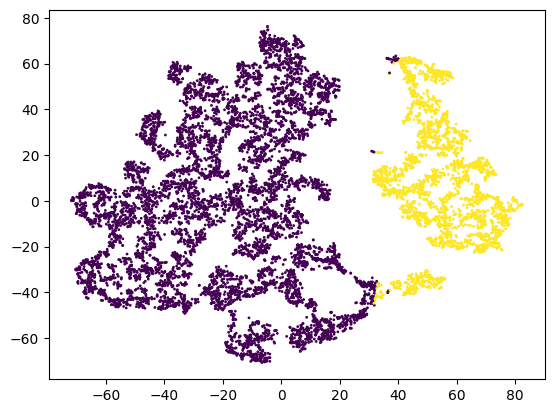

In [576]:
plt.scatter(X_tsne8[:,0], X_tsne8[:,1], s=1, c=l8)

In [1037]:
np.sum(l7 == l8)

9563

In [1038]:
torch.save(m8.state_dict(), "results4/m8_tro.pkl")

np.save("results4/tro_m8_center.npy", center_traw8)
np.save("results4/tro_m8.npy",V8)
np.save("results4/tro_m8_all.npy",V8_)

In [1039]:
import os

In [1040]:
len(os.listdir("results4/"))

170

In [1041]:
8 * 6 * 3 + 4 * 6

168

In [1042]:
4 * 6 * 4 + 4 * 6 * 3

168

In [1043]:
os.listdir("results4")

['dl_m1.npy',
 'dl_m1_all.npy',
 'dl_m2.npy',
 'dl_m2_all.npy',
 'dl_m3.npy',
 'dl_m3_all.npy',
 'dl_m3_center.npy',
 'dl_m4.npy',
 'dl_m4_all.npy',
 'dl_m4_center.npy',
 'dl_m5.npy',
 'dl_m5_all.npy',
 'dl_m6.npy',
 'dl_m6_all.npy',
 'dl_m7.npy',
 'dl_m7_all.npy',
 'dl_m7_center.npy',
 'dl_m8.npy',
 'dl_m8_all.npy',
 'dl_m8_center.npy',
 'dre_m1.npy',
 'dre_m1_all.npy',
 'dre_m2.npy',
 'dre_m2_all.npy',
 'dre_m3.npy',
 'dre_m3_all.npy',
 'dre_m3_center.npy',
 'dre_m4.npy',
 'dre_m4_all.npy',
 'dre_m4_center.npy',
 'dre_m5.npy',
 'dre_m5_all.npy',
 'dre_m6.npy',
 'dre_m6_all.npy',
 'dre_m7.npy',
 'dre_m7_all.npy',
 'dre_m7_center.npy',
 'dre_m8.npy',
 'dre_m8_all.npy',
 'dre_m8_center.npy',
 'm1_dl.pkl',
 'm1_dre.pkl',
 'm1_ps.pkl',
 'm1_tps.pkl',
 'm1_tra.pkl',
 'm1_tro.pkl',
 'm2_dl.pkl',
 'm2_dre.pkl',
 'm2_ps.pkl',
 'm2_tps.pkl',
 'm2_tra.pkl',
 'm2_tro.pkl',
 'm3_dl.pkl',
 'm3_dre.pkl',
 'm3_ps.pkl',
 'm3_tps.pkl',
 'm3_tra.pkl',
 'm3_tro.pkl',
 'm4_dl.pkl',
 'm4_dre.pkl',
 'm4_ps

In [1044]:
!zip of.zip results4/*

  adding: results4/dl_m1.npy (deflated 8%)
  adding: results4/dl_m1_all.npy (deflated 8%)
  adding: results4/dl_m2.npy (deflated 8%)
  adding: results4/dl_m2_all.npy (deflated 8%)
  adding: results4/dl_m3.npy (deflated 7%)
  adding: results4/dl_m3_all.npy (deflated 8%)
  adding: results4/dl_m3_center.npy (deflated 19%)
  adding: results4/dl_m4.npy (deflated 7%)
  adding: results4/dl_m4_all.npy (deflated 8%)
  adding: results4/dl_m4_center.npy (deflated 19%)
  adding: results4/dl_m5.npy (deflated 8%)
  adding: results4/dl_m5_all.npy (deflated 9%)
  adding: results4/dl_m6.npy (deflated 9%)
  adding: results4/dl_m6_all.npy (deflated 9%)
  adding: results4/dl_m7.npy (deflated 9%)
  adding: results4/dl_m7_all.npy (deflated 9%)
  adding: results4/dl_m7_center.npy (deflated 19%)
  adding: results4/dl_m8.npy (deflated 13%)
  adding: results4/dl_m8_all.npy (deflated 13%)
  adding: results4/dl_m8_center.npy (deflated 20%)
  adding: results4/dre_m1.npy (deflated 8%)
  adding: results4/dre_m1_all.